### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import cv2
import imagehash

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

np.set_printoptions(suppress=True)

sys.path.append("/../models-master/research")
sys.path.append("/../models-master/research/slim")

os.chdir('..')

# Model preparation 

## Loader

In [2]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [7]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models-master/research/object_detection/data/kitti_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

PATH_TO_TEST_IMAGES_2_DIR = pathlib.Path('sample-images2/image_2')
PATH_TO_TEST_IMAGES_3_DIR = pathlib.Path('sample-images2/image_3')
TEST_IMAGE_PATHS_2 = sorted(list(PATH_TO_TEST_IMAGES_2_DIR.glob("*.png")))
TEST_IMAGE_PATHS_3 = sorted(list(PATH_TO_TEST_IMAGES_3_DIR.glob("*.png")))

# Detection

Load an object detection model:

In [4]:
model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)
  print(output_dict)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [19]:
def show_inference(model, image_path_left, image_path_right):
    image_np_left = np.array(Image.open(image_path_left))
    image_np_right = np.array(Image.open(image_path_right))
    output_dict_left = run_inference_for_single_image(model, image_np_left)
    output_dict_right = run_inference_for_single_image(model, image_np_right)

    # Visualize left image
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_left,
        output_dict_left['detection_boxes'],
        output_dict_left['detection_classes'],
        output_dict_left['detection_scores'],
        category_index,
        instance_masks=output_dict_left.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=2,
        skip_scores=True,
        skip_track_ids=True)
    display(Image.fromarray(image_np_left))

    # Visualize right image
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_right,
        output_dict_right['detection_boxes'],
        output_dict_right['detection_classes'],
        output_dict_right['detection_scores'],
        category_index,
        instance_masks=output_dict_right.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3,
        skip_scores=True,
        skip_track_ids=True)
    display(Image.fromarray(image_np_right))

{'detection_scores': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>, 'detection_classes': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.,

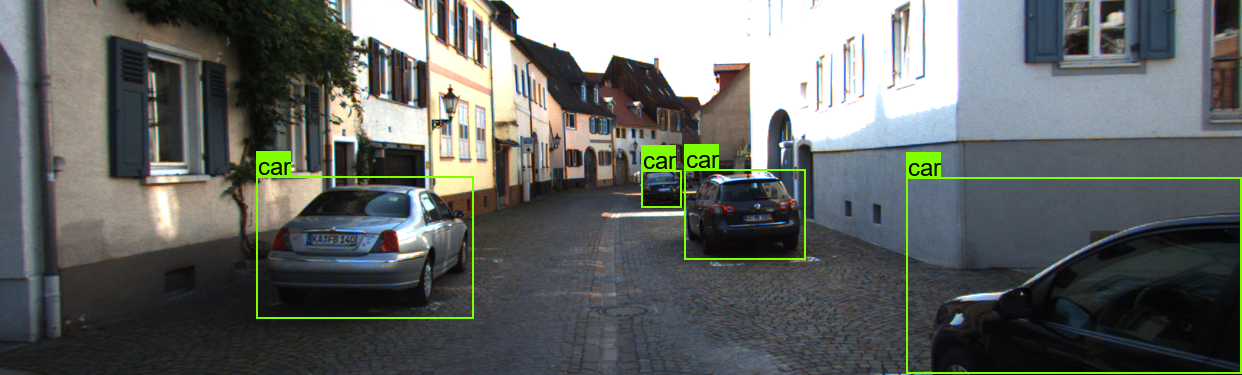

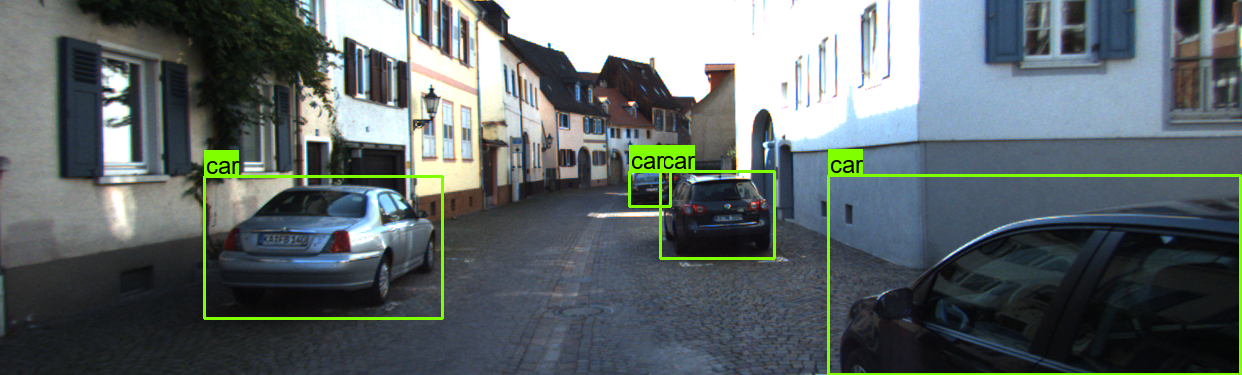

In [20]:
for image_path_2, image_path_3 in zip(TEST_IMAGE_PATHS_2, TEST_IMAGE_PATHS_3):
  show_inference(detection_model, image_path_2, image_path_3)


In [197]:
np.set_printoptions(suppress=True)